## Perturbation of sequences
### Dataset: SARS-CoV-2 S Protein sequences of Humans only - Aligned
### Number of sequences = 1311
### Reference sequence: Wuhan index sequence WIV04
### Model: Transformer

In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sarscov2-aligned',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python310.zip',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/lib-dynload',
 '',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sarscov2-aligned/../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sarscov2-aligned/../../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sarscov2-aligned/../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sarscov2-aligned/..']

In [2]:
from models.nlp.transformer import transformer, transformer_model
from models.nlp import lstm, cnn1d
from datasets.protein_sequence_dataset import ProteinSequenceDataset
from utils import utils, nn_utils, visualization_utils
from models.nlp.embedding.padding import Padding
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
cmap = sns.color_palette("vlag", as_cmap=True)

from Bio import SeqIO
from Bio.Seq import Seq
from Bio import motifs


In [3]:

input_file_path = "/home/grads/blessyantony/dev/git/zoonosis/input/data/coronaviridae/with_wiv04/cov_wiv04_s_prot_human_aligned.csv"
output_dir = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/coronaviridae/20231009/perturbed_dataset_prediction/sarscov2-S-human-aligned/transformer-l_6-h_8-lr1e-4/processed"
models_dir = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/coronaviridae/20231008"


uniprotkb_cov_human_df = pd.read_csv(input_file_path)

label_groupings = {
                    "Pig": [ "Sus scrofa (Pig) [TaxID: 9823]" ],
                    "Human": [ "Homo sapiens (Human) [TaxID: 9606]" ],
                    "Wild turkey": [ "Meleagris gallopavo (Wild turkey) [TaxID: 9103]" ],
                    "Japanese pipistrelle": [ "Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]" ],
                    "Lesser bamboo bat": [ "Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]" ],
                    "Chicken": [ "Gallus gallus (Chicken) [TaxID: 9031]" ],
                    "Bovine": [ "Bos taurus (Bovine) [TaxID: 9913]" ]
                }

amino_acid_idx_map = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5,
                  'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
                  'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15,
                  'O': 16, 'S': 17, 'U': 18, 'T': 19, 'W': 20,
                  'Y': 21, 'V': 22, 'B': 23, 'Z': 24, 'X': 25,
                  'J': 26, "-": 0}

idx_amino_acid_map = {v:k for k,v in amino_acid_idx_map.items()}
id_col = "id"
test_sequence_settings =  {
    "sequence_col": "seq_aligned",
    "batch_size": 1,
    "max_sequence_length": 2169,
    "pad_sequence_val": 0,
    "truncate": True,
    "feature_type": "token"
}


label_settings = {
    "label_col": "virus_host",
    "exclude_labels": [ "nan"],
    "label_groupings":  label_groupings
}

model = {
    "max_seq_len": 2169,
    "loss": "CrossEntropyLoss",
    "with_convolution": False,
    "n_heads": 8,
    "depth": 6,
    "n_tokens": 27,
    "n_classes": 7,
    "n_epochs": 10,
    "input_dim": 512, # input embedding dimension
    "hidden_dim": 1024
}

def post_plot_config():
    plt.rcParams['figure.autolayout'] = True
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 8

In [4]:
uniprotkb_cov_human_df

,id,seq,virus,seq_len,virus_host,binary_label,seq_aligned,aligned_seq_len,aligned_token_count
0,P0DTC2,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,Severe acute respiratory syndrome coronavirus ...,1273,Homo sapiens (Human) [TaxID: 9606],Human,---------MFVFLVLL-----------------------------...,2169,1273
1,P15423,MFVLLVAYALLHIAGCQTTNGLNTSYSVCNGCVGYSENVFAVESGG...,Human coronavirus 229E (HCoV-229E),1173,Homo sapiens (Human) [TaxID: 9606],Human,------MFVLLVAY--------------------------------...,2169,1173
2,P36334,MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNG...,Human coronavirus OC43 (HCoV-OC43),1353,Homo sapiens (Human) [TaxID: 9606],Human,-----------MFLILL------ISLPTAFAVI---GDLKCTSD--...,2169,1353
3,Q0ZME7,MFLIIFILPTTLAVIGDFNCTNSFINDYNKTIPRISEDVVDVSLGL...,Human coronavirus HKU1 (isolate N5) (HCoV-HKU1),1351,Homo sapiens (Human) [TaxID: 9606],Human,-----------MFLIIF------I-LPTTLAVI---GDFNCTNS--...,2169,1351
4,Q14EB0,MFLIIFILPTTLAVIGDFNCTNSFINDYNKTIPRISEDVVDVSLGL...,Human coronavirus HKU1 (isolate N2) (HCoV-HKU1),1351,Homo sapiens (Human) [TaxID: 9606],Human,-----------MFLIIF------I-LPTTLAVI---GDFNCTNS--...,2169,1351
...,...,...,...,...,...,...,...,...,...
2396,T1PZ81,MFLILLISLPTAFAVIGDLNCPLDTRLKGSFNNRDTGPPSISTDTV...,Human coronavirus OC43 (HCoV-OC43),929,Homo sapiens (Human) [TaxID: 9606],Human,-----------MFLILL------ISLPTAFAVI---GDLNCPLD-T...,2169,929
2397,T1PZ82,QADSFTCNNIDAAKIYGMCFSSITIDKFAIPNRRKVDLQLGNLGYL...,Human coronavirus OC43 (HCoV-OC43),297,Homo sapiens (Human) [TaxID: 9606],Human,----------------------------------------------...,2169,297
2398,T1PZ83,MFLILLISLPTAFAVIGDLNCPLDPRLKGSFNNRDTGPPSISTDTV...,Human coronavirus OC43 (HCoV-OC43),933,Homo sapiens (Human) [TaxID: 9606],Human,-----------MFLILL------ISLPTAFAVI---GDLNCPLD-P...,2169,933
2399,U3PXJ8,TYNCTDAVLTYSSFGVCADGSIIAVQPRNVSYDSVSAIVTANLSIP...,Human coronavirus 229E (HCoV-229E),585,Homo sapiens (Human) [TaxID: 9606],Human,----------------------------------------------...,2169,585


In [5]:
sarscov2_human_ids = pd.read_csv("/home/grads/blessyantony/dev/git/zoonosis/input/data/coronaviridae/sarscov2/sarscov2_top_7_hosts_human.csv")["id"].unique()
# add wuhan index sequence WIV04 to the list of sarscov2_human_ids
sarscov2_human_ids = np.append(sarscov2_human_ids, "WIV04")

uniprotkb_sarscov2_human_df = uniprotkb_cov_human_df[uniprotkb_cov_human_df["id"].isin(sarscov2_human_ids)]
uniprotkb_sarscov2_human_df

,id,seq,virus,seq_len,virus_host,binary_label,seq_aligned,aligned_seq_len,aligned_token_count
0,P0DTC2,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,Severe acute respiratory syndrome coronavirus ...,1273,Homo sapiens (Human) [TaxID: 9606],Human,---------MFVFLVLL-----------------------------...,2169,1273
160,A0A679G9E9,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,Severe acute respiratory syndrome coronavirus ...,1273,Homo sapiens (Human) [TaxID: 9606],Human,---------MFVFLVLL-----------------------------...,2169,1273
161,A0A6B9XJC0,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,Severe acute respiratory syndrome coronavirus ...,1273,Homo sapiens (Human) [TaxID: 9606],Human,---------MFVFLVLL-----------------------------...,2169,1273
162,A0A6C0QGH5,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,Severe acute respiratory syndrome coronavirus ...,1273,Homo sapiens (Human) [TaxID: 9606],Human,---------MFVFLVLL-----------------------------...,2169,1273
163,A0A6C0RQ44,MFVFLVLLPLVSSQCVNLTTRTQLPPANTNSFTRGVYYPDKVFRSS...,Severe acute respiratory syndrome coronavirus ...,1273,Homo sapiens (Human) [TaxID: 9606],Human,---------MFVFLVLL-----------------------------...,2169,1273
...,...,...,...,...,...,...,...,...,...
2214,A0A8B6RJ74,VYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDN...,Severe acute respiratory syndrome coronavirus ...,1238,Homo sapiens (Human) [TaxID: 9606],Human,----------------------------------------------...,2169,1238
2215,A0A8B6RJP7,SQCVNLTTRTQLPPAYTNSFTXGVYYPDKVFRSSVLHSTQDLFLPF...,Severe acute respiratory syndrome coronavirus ...,1261,Homo sapiens (Human) [TaxID: 9606],Human,----------------------------------------------...,2169,1261
2216,A0A8B6RME8,GVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFD...,Severe acute respiratory syndrome coronavirus ...,1239,Homo sapiens (Human) [TaxID: 9606],Human,----------------------------------------------...,2169,1239
2217,A0A8B6RX22,GVYYPDKVFRSSVLYSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFD...,Severe acute respiratory syndrome coronavirus ...,1239,Homo sapiens (Human) [TaxID: 9606],Human,----------------------------------------------...,2169,1239


In [6]:
def get_token_dataset_loader(df, sequence_settings, label_settings):
    label_col = label_settings["label_col"]
    
    seq_col = sequence_settings["sequence_col"]
    batch_size = sequence_settings["batch_size"]
    max_seq_len = sequence_settings["max_sequence_length"]
    pad_sequence_val = sequence_settings["pad_sequence_val"]
    truncate = sequence_settings["truncate"]
    
    df = df[[seq_col, label_col]]
    df, index_label_map = utils.transform_labels(df, label_settings, classification_type="multi")

    dataset = ProteinSequenceDataset(df, seq_col, max_seq_len, truncate, label_col)
    return index_label_map, DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True,
                      collate_fn=Padding(max_seq_len, pad_sequence_val))


def get_dataset_loader_for_seq(uniprot_id):
    id_df = uniprotkb_sarscov2_human_df[uniprotkb_sarscov2_human_df["id"] == uniprot_id]
    index_label_map, dataset_loader =  get_token_dataset_loader(id_df, test_sequence_settings, label_settings)
    return id_df, index_label_map, dataset_loader

def get_aligned_seq(uniprot_id):
    aligned_seq_row = uniprotkb_sarscov2_human_aligned_df[uniprotkb_sarscov2_human_aligned_df["id"] == sarscov2_human_uniprot_id]
    aligned_seq = aligned_seq_row["seq"].values[0]
    aligned_token_count = aligned_seq_row["aligned_token_count"].values[0]
    return aligned_seq, aligned_token_count

### Load the model

In [ ]:
tf_custom_model = transformer.get_transformer_model(model)
tf_custom_model.load_state_dict(torch.load(os.path.join(models_dir, "aligned_host_multi_lr1e-3-e50", "transformer-l_6-h_8-lr1e-3_itr0.pth")))
tf_custom_model = tf_custom_model.to(nn_utils.get_device())
tf_custom_model.eval()
tf_custom_model.zero_grad()

In [ ]:
def validate(model, dataset_loader, index_label_map):
    with torch.no_grad():
        model.eval()

        results = []

        for _, data in enumerate(dataset_loader):
            # get input and labels; data is a list of [(inputs, labels)]
            inputs, labels = data

            output = model(inputs)

            # tensorboard + logs

            # to get probabilities of the output
            output = F.softmax(output, dim=-1)
            result_df = pd.DataFrame(output.cpu().numpy())
            result_df.rename(columns=index_label_map, inplace=True)
            result_df["y_true"] = labels.cpu().numpy()
            result_df["y_true"] = result_df["y_true"].map(index_label_map)
            
            results.append(result_df)
    
    return inputs, pd.concat(results, ignore_index=True)

In [ ]:
def get_aligned_seq_pos_mapping(seq):
    aligned_seq_pos_map = {}
    token_count = 0
    for i, token in enumerate(seq):
        if token == "-":
            aligned_seq_pos_map[i] = 0
        else:
            token_count += 1
            aligned_seq_pos_map[i] = token_count
    return aligned_seq_pos_map

In [ ]:
output_files = os.listdir(output_dir)
print(f"Number of perturbed output files = {len(output_files)}")

diff_dfs_seq_pos = []
diff_dfs_perturb_pos = []
wiv04_perturbed_df = None
wiv04_aligned_seq_pos_map = None
for output_file in output_files:
    regex_result = re.search(r"tf\_coronaviridae\_top\_7\_host\_human\_aligned.csv\_([A-Z0-9]+)\.csv", output_file)
    uniprot_id = regex_result.group(1)
    uniprot_id_df, index_label_map, dataset_loader = get_dataset_loader_for_seq(uniprot_id)
    
    inputs, output_df = validate(tf_custom_model, dataset_loader, index_label_map)
    perturbed_output_df = pd.read_csv(os.path.join(output_dir, output_file))
    orig_seq = uniprot_id_df["seq_aligned"].values[0]
    aligned_seq_pos_map = get_aligned_seq_pos_mapping(orig_seq)
    orig_seq_human_pred = output_df["Human"].values[0]
    perturbed_output_df = perturbed_output_df[["Human", "id", "orig_token", "perturb_pos", "new_token"]]
    perturbed_output_df["seq_pos"] = perturbed_output_df["perturb_pos"].apply(lambda x: aligned_seq_pos_map[x])
    perturbed_output_df["pred_diff"] = perturbed_output_df["Human"] - orig_seq_human_pred
    diff_dfs_seq_pos.append(perturbed_output_df.pivot(columns="seq_pos", index="new_token", values="pred_diff"))
    diff_dfs_perturb_pos.append(perturbed_output_df.pivot(columns="perturb_pos", index="new_token", values="pred_diff"))
    
    if uniprot_id == "WIV04":
        wiv04_perturbed_output_df = perturbed_output_df
        wiv04_aligned_seq_pos_map = aligned_seq_pos_map

In [33]:
wiv04_perturbed_output_df

,Human,id,orig_token,perturb_pos,new_token,seq_pos,pred_diff
0,0.693698,WIV04,H,1995,L,1159,0.003585
1,0.689111,WIV04,N,188,I,87,-0.001002
2,0.690143,WIV04,L,1757,Q,959,0.000029
3,0.690662,WIV04,I,2050,M,1198,0.000549
4,0.689081,WIV04,K,2100,U,1245,-0.001033
...,...,...,...,...,...,...,...
31821,0.691906,WIV04,I,1248,Y,584,0.001792
31822,0.691379,WIV04,V,1240,W,576,0.001266
31823,0.691266,WIV04,T,1881,C,1076,0.001153
31824,0.689762,WIV04,A,1069,D,522,-0.000352


In [34]:
wiv04_perturbed_output_df.sort_values(by="Human").head(50)

,Human,id,orig_token,perturb_pos,new_token,seq_pos,pred_diff
28070,0.002169,WIV04,E,268,H,132,-0.687944
2307,0.002274,WIV04,F,269,H,133,-0.687840
1723,0.004119,WIV04,C,267,H,131,-0.685995
27811,0.004225,WIV04,Q,270,H,134,-0.685889
3291,0.013866,WIV04,F,271,H,135,-0.676248
24862,0.014603,WIV04,V,266,H,130,-0.675511
13091,0.038169,WIV04,G,1194,H,548,-0.651944
22472,0.038902,WIV04,T,1195,H,549,-0.651212
5247,0.040987,WIV04,T,1193,H,547,-0.649127
13128,0.048721,WIV04,L,1192,H,546,-0.641392


/tmp/ipykernel_15538/2904577823.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(wiv04_perturbed_output_df["Human"])


<Figure size 640x480 with 0 Axes>

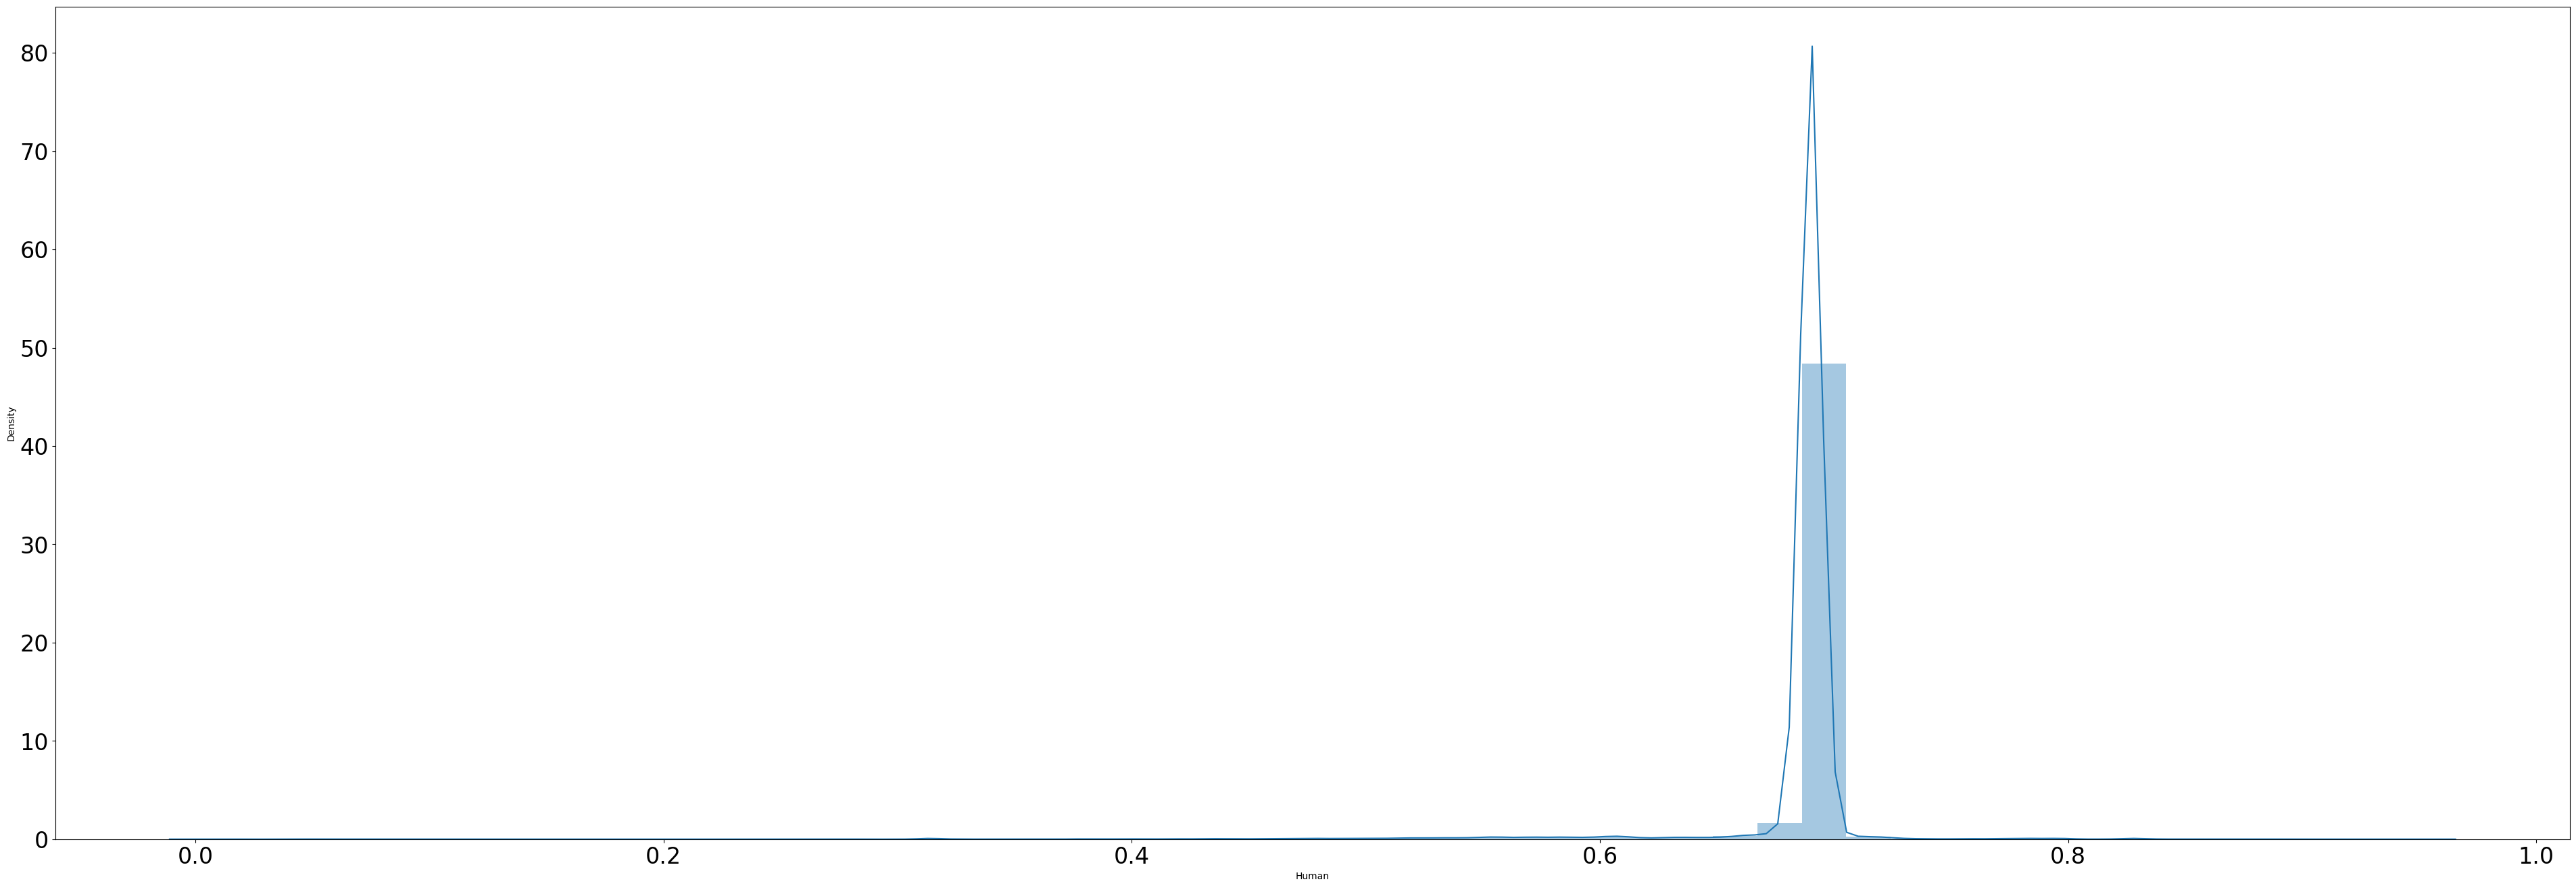

In [35]:
plt.clf()
plt.figure(figsize=(48, 16))
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
sns.distplot(wiv04_perturbed_output_df["Human"])
plt.show()

In [36]:
df = wiv04_perturbed_output_df.pivot(columns="seq_pos", index="new_token", values="pred_diff")
# remove B, Z, X, J perturbations
mod_df = df.drop(index=["B", "Z", "X", "J"])
mod_df

seq_pos,1,2,3,4,5,6,7,8,9,10,...,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273
new_token,,,,,,,,,,,,,,,,,,,,,
A,-8.832445e-04,0.000735,0.000250,0.000811,0.000606,0.000268,0.000276,0.000189,0.000194,-0.000230,...,3.735554e-05,-0.000141,-0.000897,0.000305,-0.000031,-0.000902,-0.000082,0.004550,-0.001469,0.000082
C,6.899555e-04,0.002546,0.002433,0.003336,0.003231,0.002725,0.002488,0.002240,0.002376,0.001854,...,1.109356e-03,0.000855,0.000024,0.001386,0.001145,0.000288,0.001032,0.005526,-0.000513,0.001076
D,-1.196684e-03,0.000448,-0.000031,0.000460,0.000101,-0.000417,-0.000498,-0.000558,-0.000090,-0.000546,...,-1.221445e-04,-0.000319,-0.001091,0.000163,-0.000169,-0.001028,-0.000203,0.004425,-0.001597,-0.000032
E,-1.467944e-03,0.000192,-0.000278,0.000248,-0.000049,-0.000502,-0.000545,-0.000576,-0.000255,-0.000675,...,-4.493045e-04,-0.000615,-0.001355,-0.000164,-0.000489,-0.001357,-0.000540,0.004083,-0.001949,-0.000389
F,-1.689794e-03,NaN,-0.000475,NaN,-0.000369,-0.000834,-0.000801,-0.000741,-0.000226,-0.000620,...,-4.917445e-04,-0.000688,-0.001461,-0.000185,-0.000520,-0.001396,-0.000589,0.004027,-0.002022,-0.000475
G,-1.180744e-03,0.000528,0.000122,0.000688,0.000374,-0.000114,-0.000179,-0.000239,0.000205,-0.000172,...,-3.144145e-04,-0.000497,-0.001237,NaN,-0.000355,-0.001218,-0.000370,0.004278,-0.001710,-0.000138
H,-8.791444e-03,-0.006749,-0.007546,-0.008583,-0.011823,-0.015532,-0.015814,-0.012189,-0.002039,-0.001930,...,-3.629644e-03,-0.003693,-0.004248,-0.000723,-0.001148,-0.003580,-0.004250,NaN,-0.005777,-0.003713
I,-6.864045e-04,0.000921,0.000433,0.001016,0.000824,0.000478,0.000464,0.000350,0.000368,-0.000064,...,2.040555e-04,0.000029,-0.000732,0.000411,0.000099,-0.000746,0.000077,0.004690,-0.001342,0.000197
K,-1.005414e-03,0.000523,0.000178,0.001059,0.001108,0.000933,0.000976,0.000883,0.001192,0.000780,...,9.095055e-04,0.000745,NaN,0.001150,0.000846,NaN,0.000798,0.005354,-0.000677,0.000865


<Figure size 640x480 with 0 Axes>

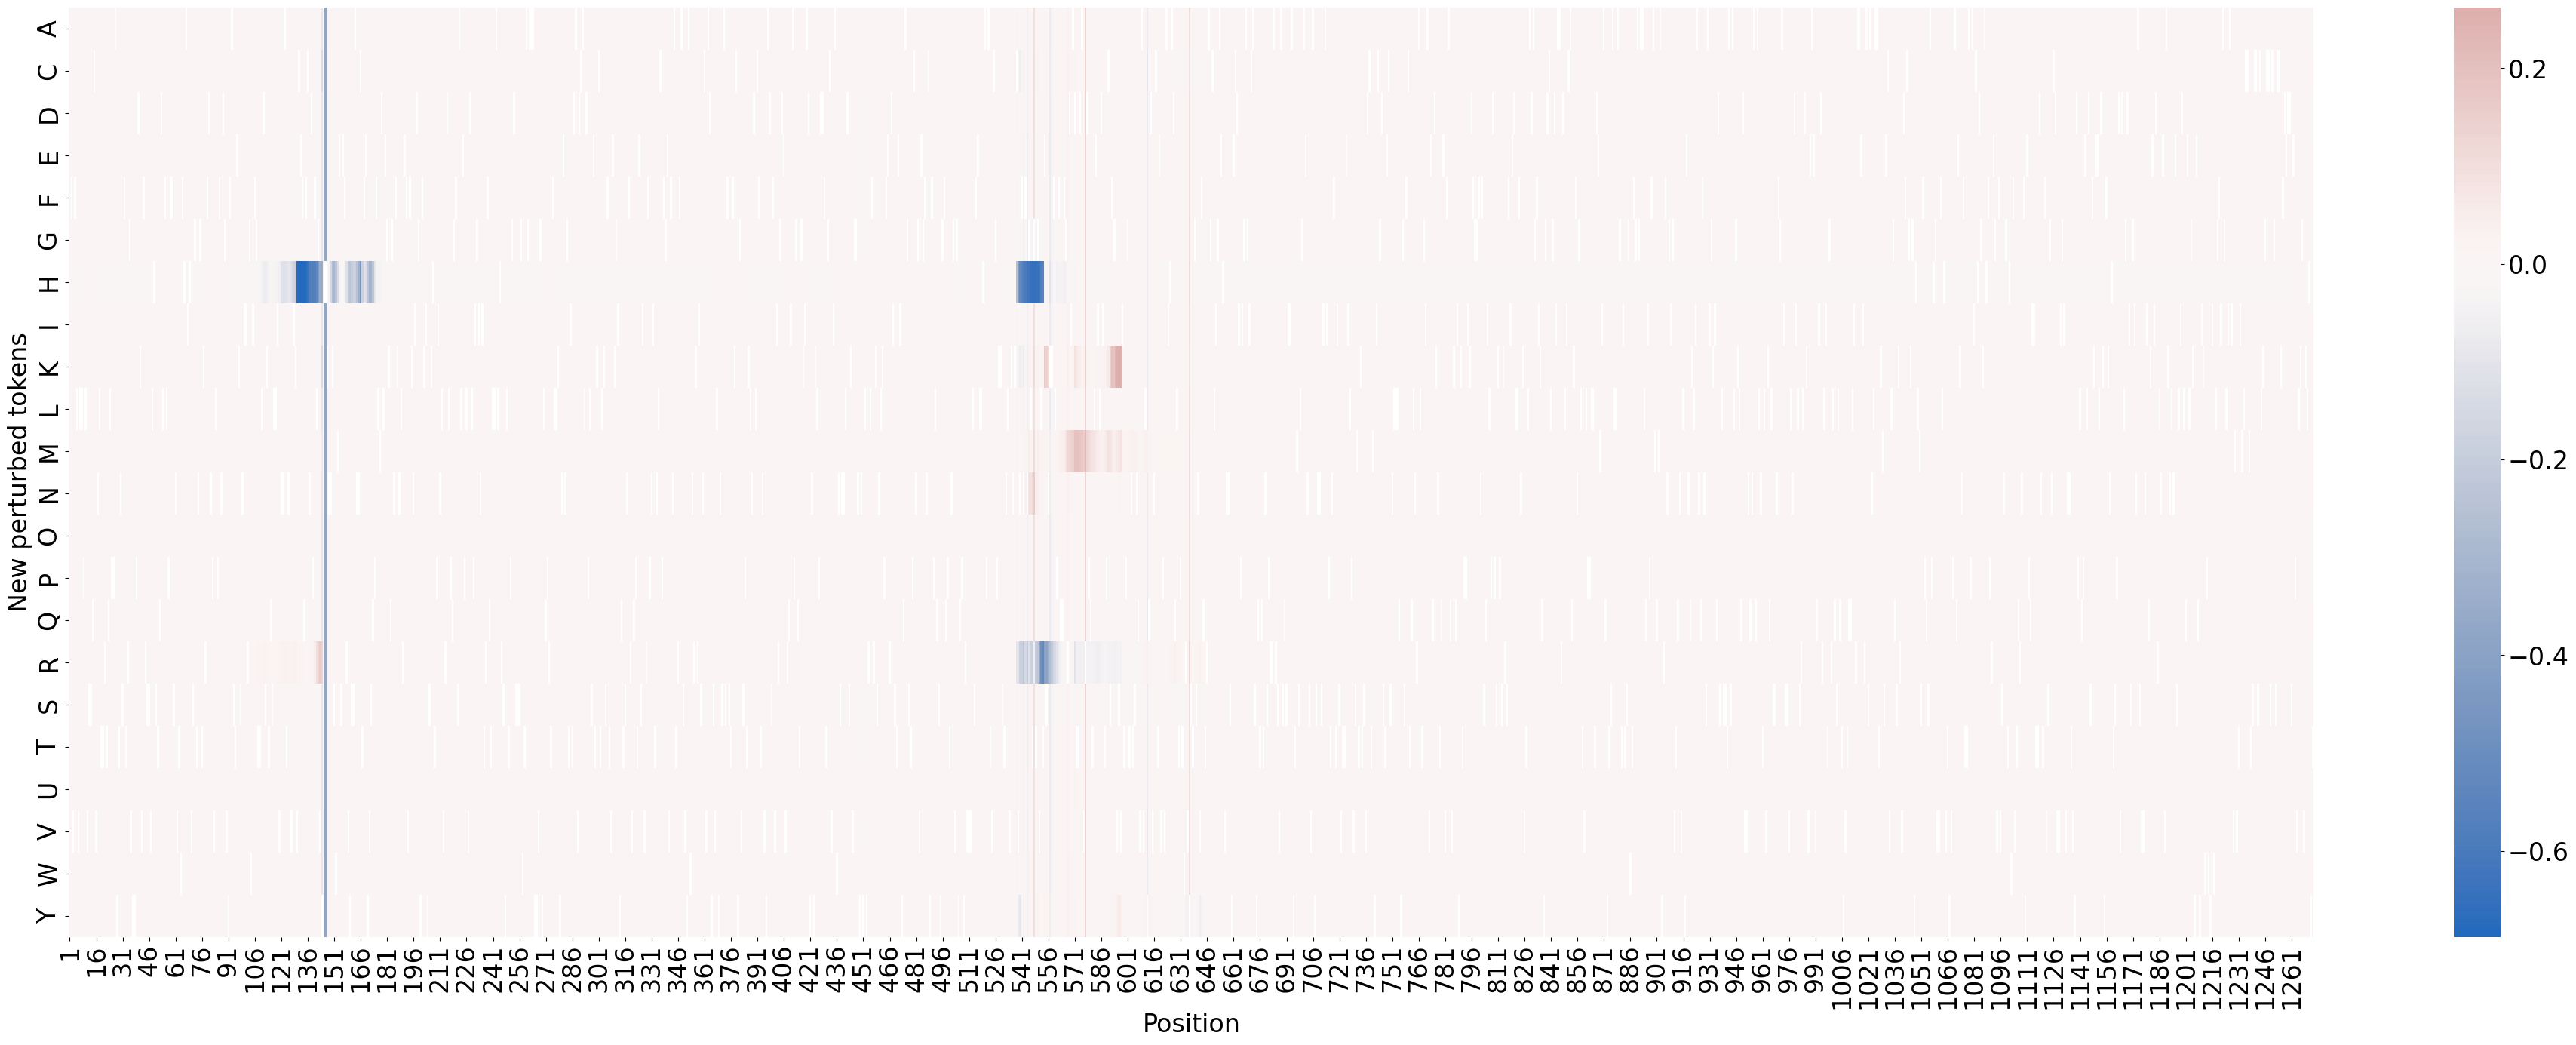

In [37]:
# visualization_utils.pre_plot_config(figsize=(40, 20))
plt.clf()
plt.figure(figsize=(48, 16))
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
# plt.rcParams['figure.autolayout'] = True
ax = sns.heatmap(mod_df, cmap=cmap, center=0)
plt.xlabel('Position', fontsize=24)
plt.ylabel('New perturbed tokens', fontsize=24)
plt.show()

In [38]:
def print_histogram(values, n_bins=12):
    n = len(values)
    freq, bins = np.histogram(values, bins=n_bins)
    hist_map = []
    for i in range(n_bins):
        hist_map.append({"start": bins[i], "end":bins[i+1], "count": freq[i], "percentage": freq[i]/n*100})


    hist_df = pd.DataFrame(hist_map)
    print(hist_df.head(20))

<Figure size 640x480 with 0 Axes>

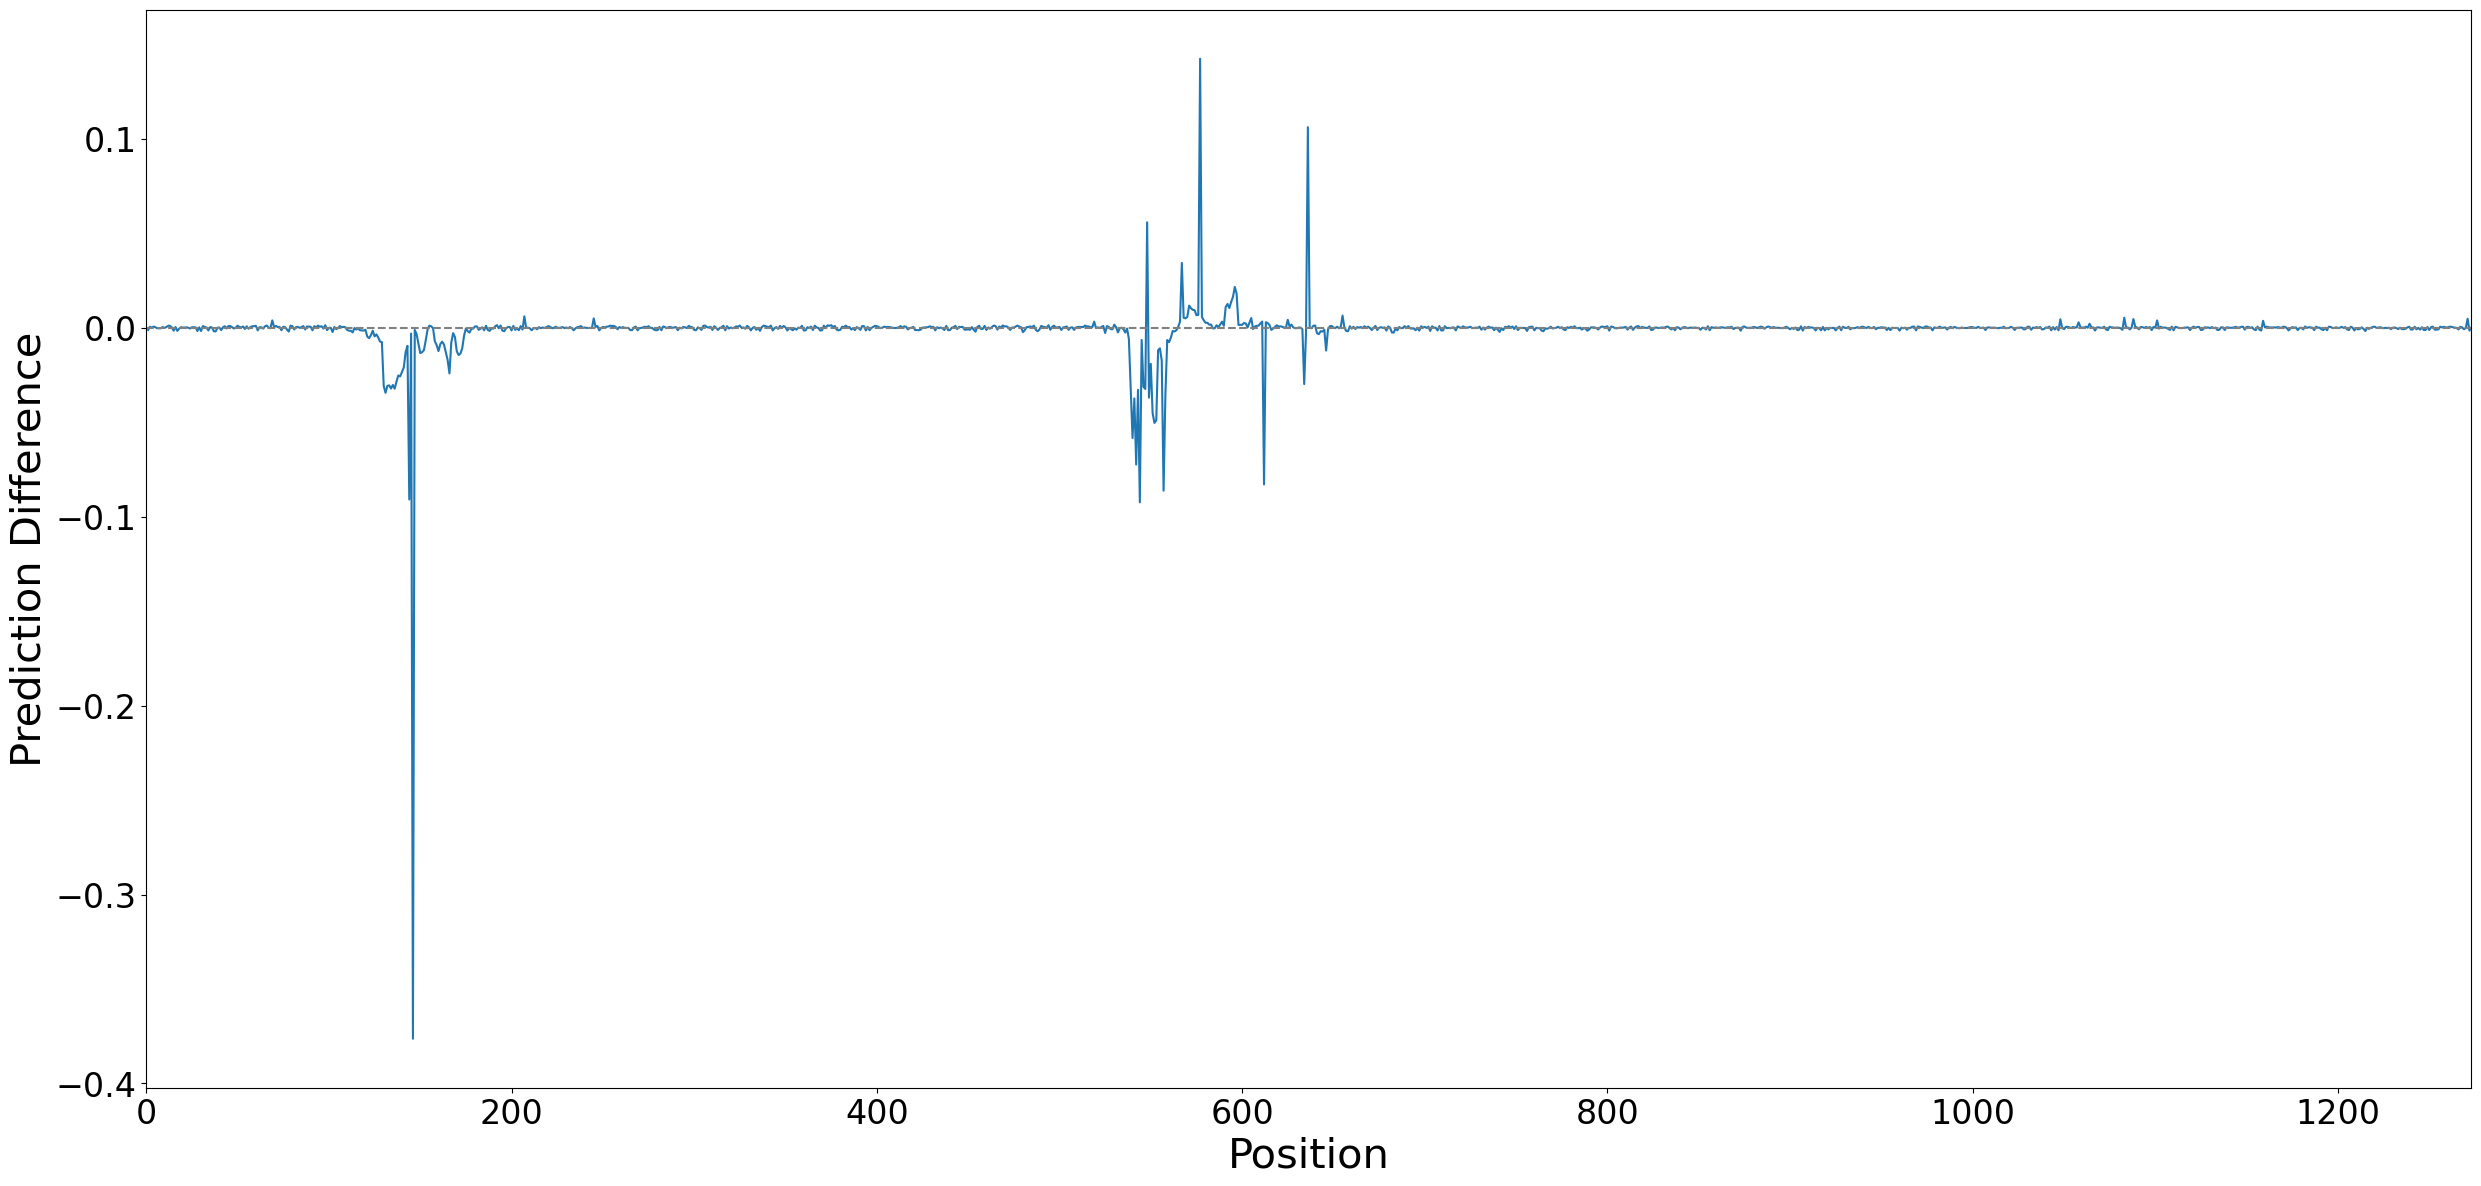

In [39]:
plt.clf()
plt.figure(figsize=(30, 14))
ax = sns.lineplot(mod_df.mean(axis=0))
ax.axhline(0.0, color="gray", linestyle="--")
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.xlabel('Position', fontsize=30)
plt.ylabel('Prediction Difference', fontsize=30)
ax.set_xlim(0, 1273)
plt.show()

In [40]:
mod_df.mean(axis=0).nsmallest(20)

seq_pos
146   -0.376316
544   -0.092446
144   -0.090918
557   -0.086249
612   -0.082956
542   -0.072430
540   -0.058396
552   -0.050399
553   -0.049060
551   -0.045230
541   -0.037413
549   -0.037046
558   -0.035525
131   -0.034498
543   -0.032884
547   -0.032417
136   -0.032262
134   -0.032198
539   -0.031542
546   -0.031320
dtype: float64

In [43]:
print_histogram(wiv04_perturbed_output_df["pred_diff"])

       start       end  count  percentage
0  -0.687944 -0.608770     15    0.047131
1  -0.608770 -0.529595     11    0.034563
2  -0.529595 -0.450420      3    0.009426
3  -0.450420 -0.371246     32    0.100547
4  -0.371246 -0.292071     28    0.087978
5  -0.292071 -0.212897     89    0.279646
6  -0.212897 -0.133722    290    0.911205
7  -0.133722 -0.054547    511    1.605605
8  -0.054547  0.024627  30595   96.132093
9   0.024627  0.103802    173    0.543581
10  0.103802  0.182976     68    0.213662
11  0.182976  0.262151     11    0.034563


### Identify important position across all sequences

In [44]:
mean_diff_dfs = [x_df.mean(axis=0) for x_df in diff_dfs_perturb_pos]

In [46]:
mean_diff_df = pd.DataFrame(mean_diff_dfs)
mean_diff_df

perturb_pos,9,10,11,12,13,14,15,16,74,75,...,2166,0,1,2,3,4,5,6,7,8
0,-0.001358,-0.000773,-0.000822,-0.000374,-0.000341,-0.000223,-0.000210,-0.000147,-0.000034,0.000104,...,-0.002066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.000859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.000112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.004769,-0.002905,-0.003007,-0.001686,-0.001262,-0.001569,-0.001445,-0.001269,0.000297,-0.000014,...,-0.005576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.004753,-0.002882,-0.002985,-0.001666,-0.001247,-0.001563,-0.001444,-0.001269,0.000302,-0.000013,...,-0.005549,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1307,-0.000269,0.000123,0.000017,0.000150,-0.000056,0.000028,-0.000054,-0.000045,-0.000385,-0.000118,...,-0.000149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1308,-0.003214,-0.001268,-0.001547,-0.000217,-0.000182,-0.000627,-0.000796,-0.000725,0.000925,0.000506,...,-0.003966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1309,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.000108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1310,NaN,-0.000280,-0.000370,-0.000113,-0.000202,-0.000127,-0.000150,-0.000104,-0.000301,-0.000063,...,-0.001099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
# retain only columns with respect to WIV04 aligned sequence
wiv04_token_cols = wiv04_perturbed_output_df["perturb_pos"].unique()
print(len(wiv04_token_cols))
wiv04_token_cols.sort()
wiv04_token_cols

1273


array([   9,   10,   11, ..., 2164, 2165, 2166])

In [48]:
mean_diff_df = mean_diff_df[wiv04_token_cols]
# remap the columns from pertrbation position to actual sequence position w.r.t wiv04
mean_diff_df_renamed = mean_diff_df.rename(columns=wiv04_aligned_seq_pos_map)
mean_diff_df_renamed.shape

(1312, 1273)

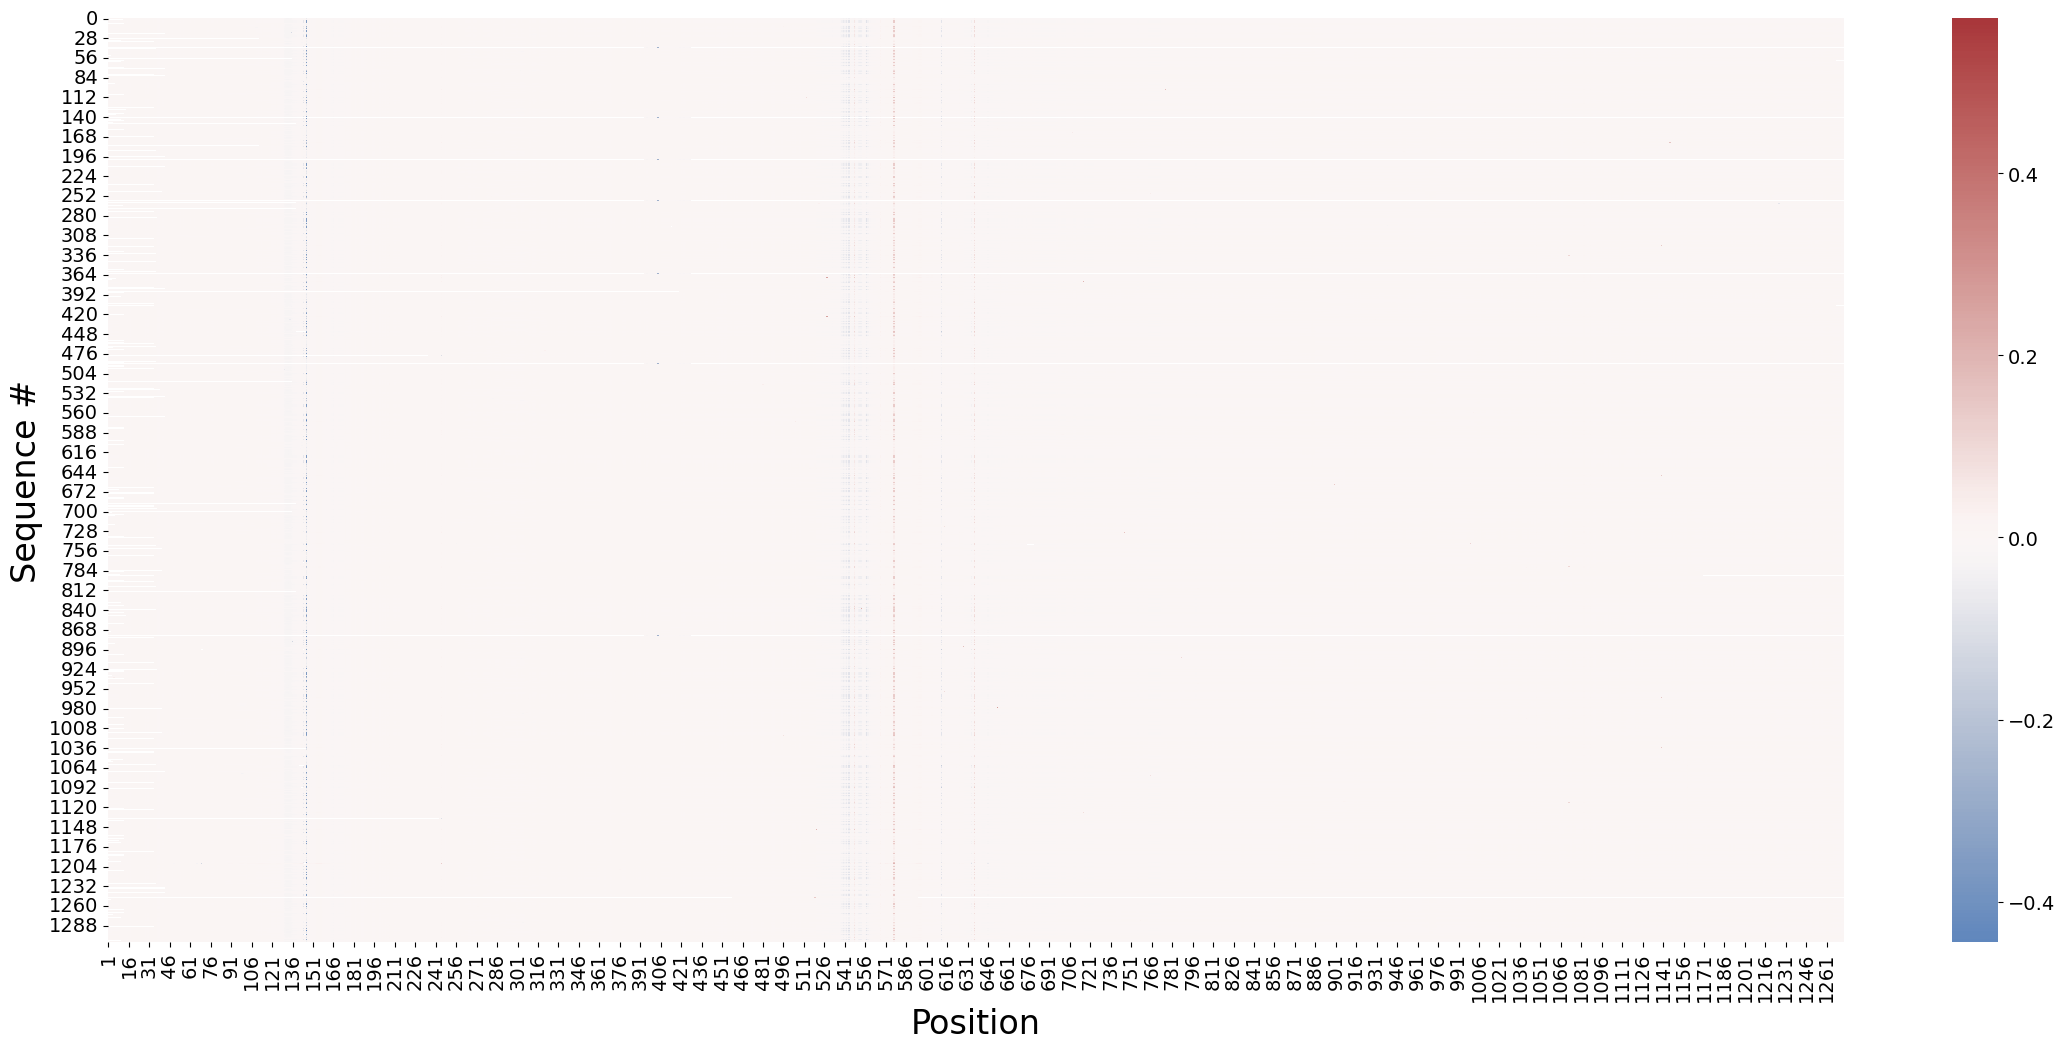

In [50]:
plt.figure(figsize=(28,12))
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
sns.heatmap(mean_diff_df_renamed, cmap=cmap, center=0)
plt.xlabel('Position', fontsize=24)
plt.ylabel('Sequence #', fontsize=24)
plt.show()

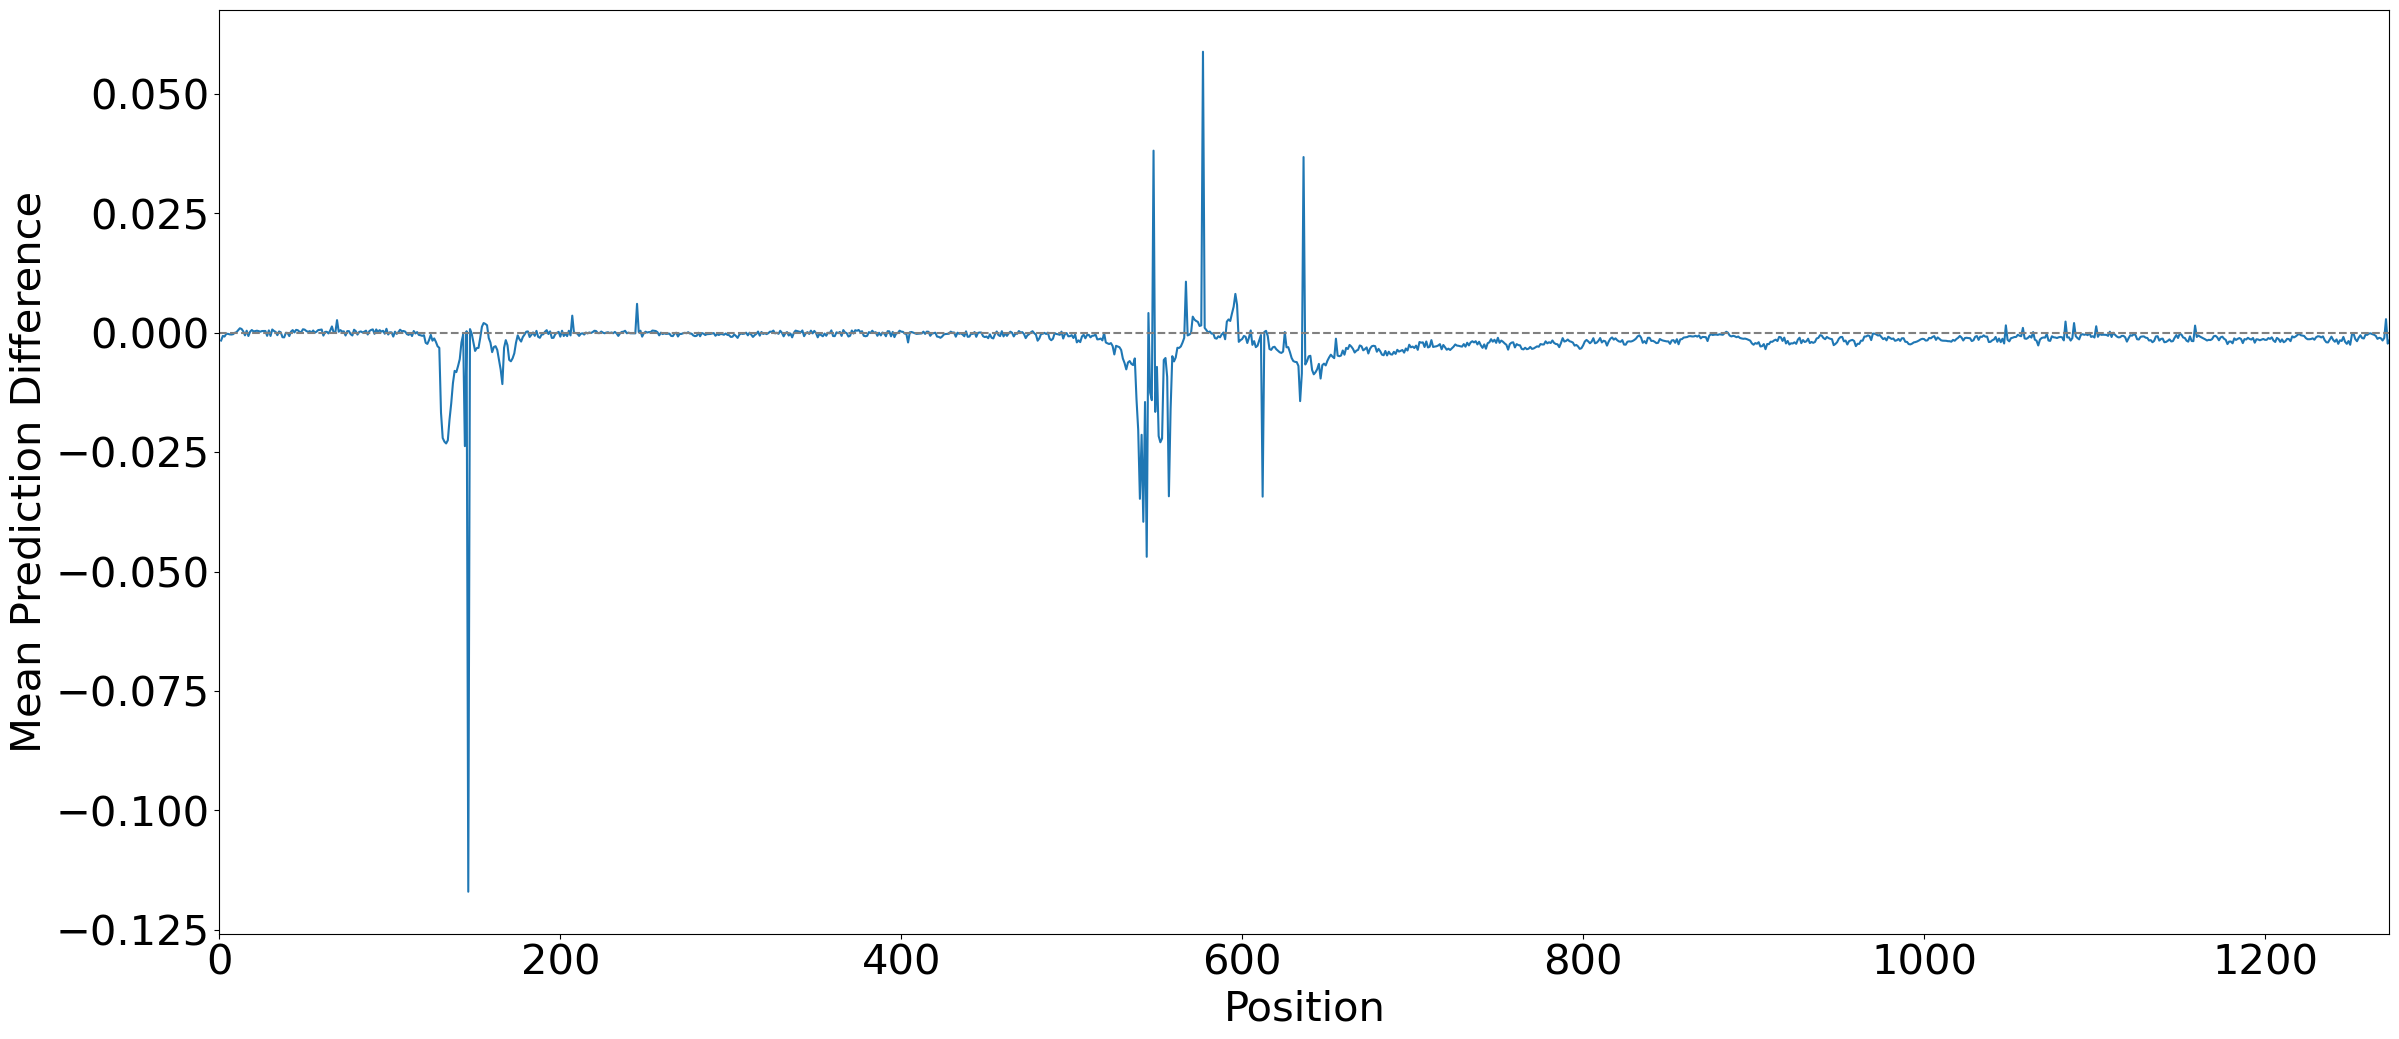

In [51]:
plt.figure(figsize=(28,12))
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
ax=sns.lineplot(mean_diff_df_renamed.mean(axis=0))
ax.axhline(0.0, color="gray", linestyle="--")
plt.xlabel('Position', fontsize=30)
plt.ylabel('Mean Prediction Difference', fontsize=30)
ax.set_xlim(0, 1273)
plt.show()

In [52]:
mean_diff_df_renamed.mean(axis=0).nsmallest(20)

perturb_pos
146   -0.117048
544   -0.046920
542   -0.039591
540   -0.034780
612   -0.034323
557   -0.034250
144   -0.023751
133   -0.023187
552   -0.022941
132   -0.022806
134   -0.022523
553   -0.022149
131   -0.022047
551   -0.021639
541   -0.021375
539   -0.020337
135   -0.018170
130   -0.016739
549   -0.016576
558   -0.016101
dtype: float64

In [53]:
print_histogram(mean_diff_df_renamed.mean(axis=0))

       start       end  count  percentage
0  -0.117048 -0.102391      1    0.078555
1  -0.102391 -0.087735      0    0.000000
2  -0.087735 -0.073078      0    0.000000
3  -0.073078 -0.058421      0    0.000000
4  -0.058421 -0.043764      1    0.078555
5  -0.043764 -0.029107      4    0.314218
6  -0.029107 -0.014450     16    1.256874
7  -0.014450  0.000207   1104   86.724273
8   0.000207  0.014864    144   11.311862
9   0.014864  0.029520      0    0.000000
10  0.029520  0.044177      2    0.157109
11  0.044177  0.058834      1    0.078555
